In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

import random
import torch.backends.cudnn as cudnn

# Setting random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Ensuring deterministic operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading the balanced biased resume dataset
data = pd.read_csv("balanced_biased_resume_dataset.csv")

# Storing Label Encodings
rencoder = LabelEncoder()
gencoder = LabelEncoder()

data['Race'] = rencoder.fit_transform(data['Race'])
data['Gender'] = gencoder.fit_transform(data['Gender'])
data['Age'] = data['Age'].astype(float)

# Normalizing demographics
data['Age'] = (data['Age'] - data['Age'].mean()) / data['Age'].std()

# Initializing BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class ResumeDataset(Dataset):
    def __init__(self, data):
        self.texts = data['Resume Text'].tolist()
        self.labels = data['Shortlisted'].tolist()
        self.demographics = data[['Race', 'Gender', 'Age']].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        demographics = torch.tensor(self.demographics[idx], dtype=torch.float)
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'demographics': demographics}

def seed_worker(worker_id):
    np.random.seed(42)
    torch.manual_seed(42)

g = torch.Generator()
g.manual_seed(42)

# Spliting data for training and validation
trdata, vdata = train_test_split(data, test_size=0.2, random_state=42)
trdataset = ResumeDataset(trdata)
vdataset = ResumeDataset(vdata)
trloader = DataLoader(trdataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g)
vloader = DataLoader(vdataset, batch_size=16, shuffle=False, worker_init_fn=seed_worker, generator=g)

# Initializing BERT Model
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits

bertm = BertClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bertm.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bertm

# Initializing TensorBoard Writer
writer = SummaryWriter()

# Keeping Early stopping parameters
patience = 3
bestval = float("inf")
epochwoimp = 0

# Training BERT with Early Stopping
for epoch in range(15):
    bertm.train()
    trloss = 0.0
    for batch in trloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = bertm(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trloss += loss.item()

    # Finding Validation loss for early stopping
    bertm.eval()
    valloss = 0.0
    with torch.no_grad():
        for batch in vloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = bertm(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            valloss += loss.item()

    # Logging training and validation loss to TensorBoard
    writer.add_scalar("Loss/train", trloss / len(trloader), epoch)
    writer.add_scalar("Loss/val", valloss / len(vloader), epoch)

    print(f"Epoch {epoch + 1} - Train Loss: {trloss / len(trloader):.4f} - Val Loss: {valloss / len(vloader):.4f}")
    
    if valloss < bestval:
        bestval = valloss
        epochwoimp = 0
        # Saving the entire model
        torch.save(bertm, "best_bertm_full.pth")

    else:
        epochwoimp += 1

    if epochwoimp >= patience:
        print("Early stopping triggered!")
        break

# Reloading best model
bertm = torch.load("best_bertm_full.pth")

# Evaluating BERT
bertm.eval()
ytrue, ypred = [], []
all_demographics = []
for batch in vloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    demographics = batch['demographics'].cpu().numpy()
    with torch.no_grad():
        outputs = bertm(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
    ytrue.extend(labels.cpu().numpy())
    ypred.extend(predictions.cpu().numpy())
    all_demographics.extend(demographics)

# Calculating classification Metrics
print(classification_report(ytrue, ypred))

roc = roc_auc_score(ytrue, ypred)
f1 = f1_score(ytrue, ypred)
print(f"AUC-ROC: {roc}")
print(f"F1 Score: {f1}")

/home/stu1/s7/sp7289/miniconda3/envs/idai610/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/stu1/s7/sp7289/miniconda3/envs/idai610/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `be

Epoch 1 - Train Loss: 0.5869 - Val Loss: 0.4134
Epoch 2 - Train Loss: 0.3877 - Val Loss: 0.3269
Epoch 3 - Train Loss: 0.3189 - Val Loss: 0.3179
Epoch 4 - Train Loss: 0.3066 - Val Loss: 0.2941
Epoch 5 - Train Loss: 0.2910 - Val Loss: 0.2960
Epoch 6 - Train Loss: 0.2754 - Val Loss: 0.3441
Epoch 7 - Train Loss: 0.2774 - Val Loss: 0.3348
Early stopping triggered!


/tmp/ipykernel_1285723/964110180.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bertm = torch.load("best_bertm_full.pth")


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       216
           1       0.84      0.78      0.81       184

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

AUC-ROC: 0.8288043478260869
F1 Score: 0.8112676056338028


In [2]:
# Initializing GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 256),  # Increased complexity
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # Output has the same size as demographic features
        )
        
    def forward(self, x):
        return self.fc(x)
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 128),  # Adjusted structure
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

# Training GAN architecture
generator = Generator()
discriminator = Discriminator()
batch = 16

gan_criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

real_labels = torch.ones(16, 1)
fake_labels = torch.zeros(16, 1)

for epoch in range(200):
    for batch in trloader:
        demographics = batch['demographics']

        # Train Discriminator
        d_optimizer.zero_grad()

        real_outputs = discriminator(demographics)
        d_real_loss = gan_criterion(real_outputs, real_labels)

        torch.manual_seed(42)  # Ensures same noise every time if seed is fixed
        z = torch.randn(16, 3)
        fakedemo = generator(z)
        fake_outputs = discriminator(fakedemo)
        d_fake_loss = gan_criterion(fake_outputs, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()

        fakedemo = generator(z)
        fake_outputs = discriminator(fakedemo)
        g_loss = gan_criterion(fake_outputs, real_labels)

        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

print("GAN Training Completed!")

Epoch 10, D Loss: 1.2966030836105347, G Loss: 0.8090513944625854
Epoch 20, D Loss: 1.5588314533233643, G Loss: 0.7938557267189026
Epoch 30, D Loss: 1.449006199836731, G Loss: 0.7171939611434937
Epoch 40, D Loss: 1.5902528762817383, G Loss: 0.5806640386581421
Epoch 50, D Loss: 1.4104559421539307, G Loss: 0.6312559843063354
Epoch 60, D Loss: 1.39894437789917, G Loss: 0.7316529154777527
Epoch 70, D Loss: 1.4491961002349854, G Loss: 0.6198535561561584
Epoch 80, D Loss: 1.3214647769927979, G Loss: 0.812291145324707
Epoch 90, D Loss: 1.3803540468215942, G Loss: 0.9205710291862488
Epoch 100, D Loss: 1.5185155868530273, G Loss: 0.7302769422531128
Epoch 110, D Loss: 1.3118634223937988, G Loss: 0.7477412819862366
Epoch 120, D Loss: 1.5145792961120605, G Loss: 0.6568757891654968
Epoch 130, D Loss: 1.3892756700515747, G Loss: 0.7105082869529724
Epoch 140, D Loss: 1.340654730796814, G Loss: 0.6995776891708374
Epoch 150, D Loss: 1.37827467918396, G Loss: 0.5957368016242981
Epoch 160, D Loss: 1.43881

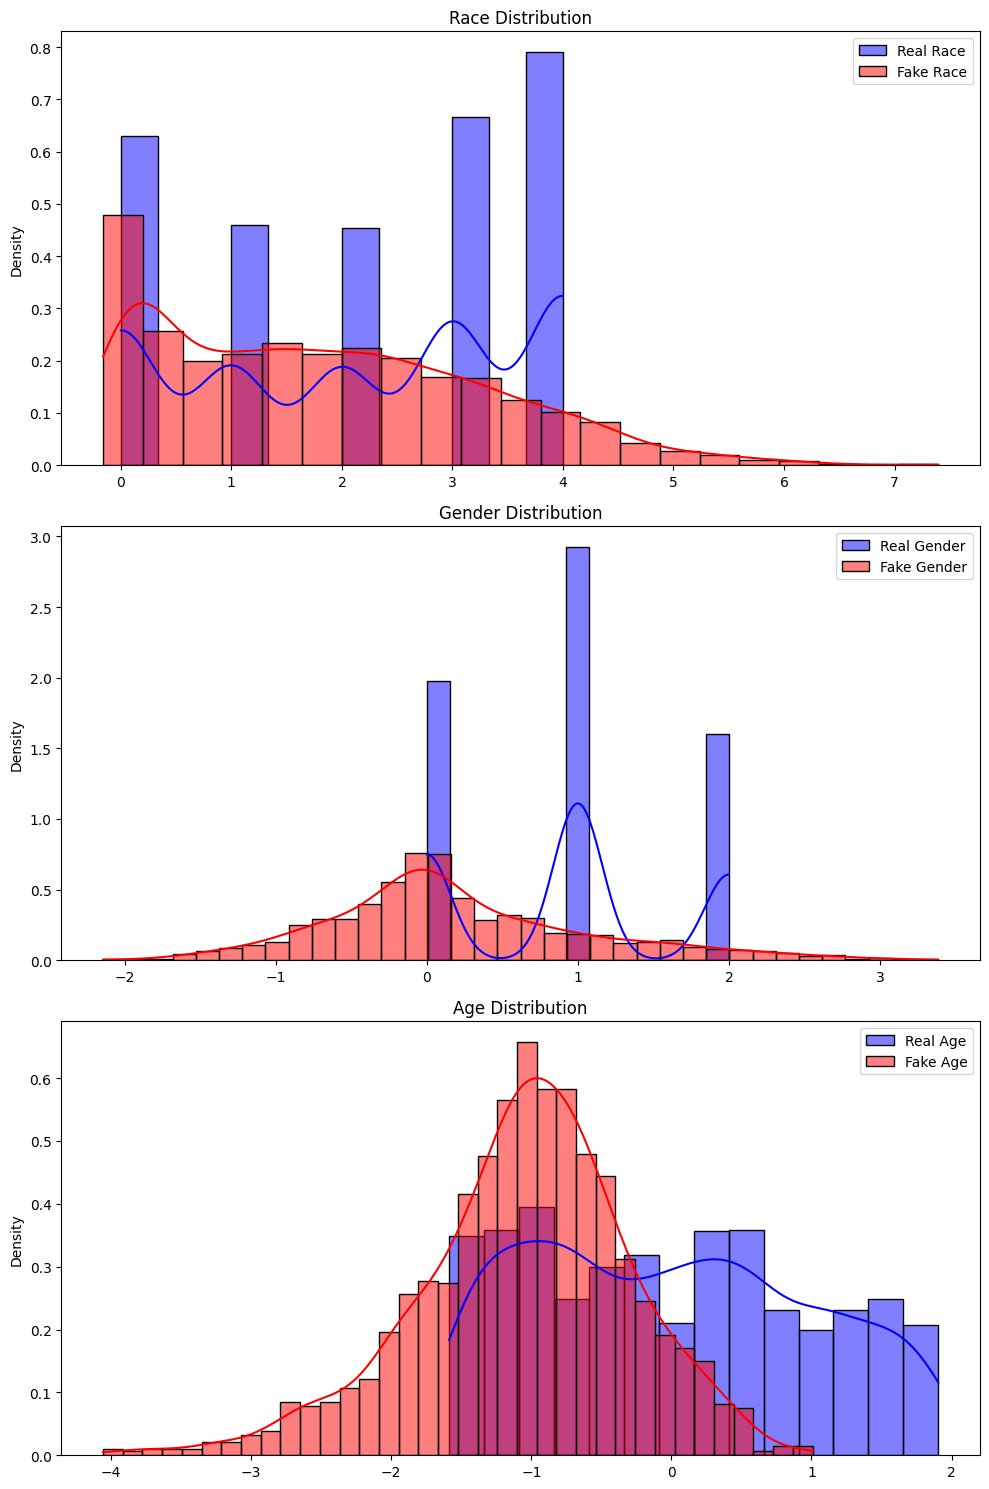

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Getting the real and generated demographic data
realdemo = data[['Race', 'Gender', 'Age']].values
fakedemo = generator(torch.randn(realdemo.shape[0], 3)).detach().numpy()

# Plotting histograms for real vs fake demographics (Race, Gender, and Age)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Visualization Race Distribution
sns.histplot(realdemo[:, 0], kde=True, label="Real Race", color='blue', ax=axes[0], stat="density")
sns.histplot(fakedemo[:, 0], kde=True, label="Fake Race", color='red', ax=axes[0], stat="density")
axes[0].set_title("Race Distribution")
axes[0].legend()

# Visualization Gender Distribution
sns.histplot(realdemo[:, 1], kde=True, label="Real Gender", color='blue', ax=axes[1], stat="density")
sns.histplot(fakedemo[:, 1], kde=True, label="Fake Gender", color='red', ax=axes[1], stat="density")
axes[1].set_title("Gender Distribution")
axes[1].legend()

# Visualization Age Distribution
sns.histplot(realdemo[:, 2], kde=True, label="Real Age", color='blue', ax=axes[2], stat="density")
sns.histplot(fakedemo[:, 2], kde=True, label="Fake Age", color='red', ax=axes[2], stat="density")
axes[2].set_title("Age Distribution")
axes[2].legend()

plt.tight_layout()
plt.show()


In [4]:
# Calculate and compare the statistics (mean and std) for real and fake demographics
real_stats = {
    'Race Mean': realdemo[:, 0].mean(),
    'Race Std': realdemo[:, 0].std(),
    'Gender Mean': realdemo[:, 1].mean(),
    'Gender Std': realdemo[:, 1].std(),
    'Age Mean': realdemo[:, 2].mean(),
    'Age Std': realdemo[:, 2].std()
}

fake_stats = {
    'Race Mean': fakedemo[:, 0].mean(),
    'Race Std': fakedemo[:, 0].std(),
    'Gender Mean': fakedemo[:, 1].mean(),
    'Gender Std': fakedemo[:, 1].std(),
    'Age Mean': fakedemo[:, 2].mean(),
    'Age Std': fakedemo[:, 2].std()
}

# Print comparison
print("Real Data Stats:")
for key, value in real_stats.items():
    print(f"{key}: {value:.4f}")

print("\nFake Data Stats:")
for key, value in fake_stats.items():
    print(f"{key}: {value:.4f}")


Real Data Stats:
Race Mean: 2.1755
Race Std: 1.4962
Gender Mean: 0.9420
Gender Std: 0.7393
Age Mean: 0.0000
Age Std: 0.9997

Fake Data Stats:
Race Mean: 1.8194
Race Std: 1.4508
Gender Mean: 0.2106
Gender Std: 0.8774
Age Mean: -1.0559
Age Std: 0.7644
